## Using ATHENA Delphes fastsim as input


Trying out things from Ben Nachman's example.

This uses the ATHENA Delphes fastsim MC as input.

Uses set of variables is E, pt, pz, Empz (redundant but useful?) for both HFS and electron as well as delta phi between HFS and electron.


This is the main NN training notebook.


Training target variables are   log(x)    AND    log(Q2)





In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3

import matplotlib as mpl



In [2]:


#has_gpu = False

has_gpu = True



#--- Hyperparameter settings.

#max_events =   120000
#max_events =   600000
#max_events =  3000000
#max_events = 15000000
max_events = 1e9


learning_rate_setval = 1e-4
batch_size_setval = 128
max_epochs = 5000
dropout_setval = 0.0



In [5]:
%%time


input_file1 = 'athena-delphes/athena-chunk1-5m.root'
input_file2 = 'athena-delphes/athena-chunk2-5m.root'

ur_file1 = uproot3.open(input_file1)
ur_file2 = uproot3.open(input_file2)

ur_tree1 = ur_file1['minitree']
ur_tree2 = ur_file2['minitree']

print (ur_file1.keys()) 

print(ur_tree1)
ur_tree1.show()




pandas_df1   =  ur_tree1.pandas.df(
    ['gene_px','gene_py','gene_pz',
     'e_px','e_py','e_pz',
     'HFS_px','HFS_py','HFS_pz','HFS_E',
     'gen_Q2',
     'gen_y',
     'Empz',
     'Q2_e','y_e',
     'Q2_da','y_da',
     'Q2_sigma','y_sigma',
     'Q2_h','y_h',
     'gen_s',
    ],
    entrystop=max_events,flatten=True)


pandas_df2   =  ur_tree2.pandas.df(
    ['gene_px','gene_py','gene_pz',
     'e_px','e_py','e_pz',
     'HFS_px','HFS_py','HFS_pz','HFS_E',
     'gen_Q2',
     'gen_y',
     'Empz',
     'Q2_e','y_e',
     'Q2_da','y_da',
     'Q2_sigma','y_sigma',
     'Q2_h','y_h',
     'gen_s',
    ],
    entrystop=max_events,flatten=True)

pandas_df = pd.concat( [pandas_df1, pandas_df2] )

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df.shape[0] )


[b'minitree;34', b'minitree;33']
<TTree b'minitree' at 0x7f1a902b6e50>
Q2_e                       (no streamer)              asdtype('>f4')
Q2_sigma                   (no streamer)              asdtype('>f4')
Q2_esigma                  (no streamer)              asdtype('>f4')
Q2_da                      (no streamer)              asdtype('>f4')
gen_Q2                     (no streamer)              asdtype('>f4')
y_e                        (no streamer)              asdtype('>f4')
y_sigma                    (no streamer)              asdtype('>f4')
y_esigma                   (no streamer)              asdtype('>f4')
y_da                       (no streamer)              asdtype('>f4')
HFS_px                     (no streamer)              asdtype('>f4')
HFS_py                     (no streamer)              asdtype('>f4')
HFS_pz                     (no streamer)              asdtype('>f4')
gen_y                      (no streamer)              asdtype('>f4')
e_px                       (no s

In [6]:
pandas_df1

,gene_px,gene_py,gene_pz,e_px,e_py,e_pz,HFS_px,HFS_py,HFS_pz,HFS_E,...,Empz,Q2_e,y_e,Q2_da,y_da,Q2_sigma,y_sigma,Q2_h,y_h,gen_s
entry,,,,,,,,,,,,,,,,,,,,,
0,-7.121248,-12.914615,-13.887268,-7.156896,-12.979266,-13.956788,6.004340,12.465102,61.221779,63.056351,...,36.150002,230.465729,0.046789,228.681366,0.054169,231.427155,0.050749,201.710144,0.050961,19800.000000
1,-14.146625,4.915292,-11.414117,-14.093822,4.896943,-11.371512,12.212230,-5.504359,27.414705,32.831879,...,35.548409,265.974945,0.163020,264.760254,0.166842,262.639038,0.152389,211.220383,0.150477,19800.000000
2,-10.514571,-11.242774,-9.968884,-10.452328,-11.176219,-9.909869,8.446683,9.736281,20.870665,26.771954,...,34.042027,299.555420,0.218312,306.828278,0.199333,283.263611,0.173353,198.716171,0.163925,19800.000000
3,3.355989,20.810322,-10.797507,3.343029,20.729967,-10.755816,-4.344270,-21.881338,197.288101,198.876633,...,35.936615,462.106384,0.045875,464.121124,0.041715,461.298431,0.044204,520.639587,0.044126,19800.000000
4,-12.956479,3.140606,-11.337905,-12.978569,3.145961,-11.357235,13.664036,-3.141085,21.651905,28.835464,...,36.071541,222.246109,0.197555,223.923386,0.191499,222.688049,0.199148,245.575241,0.199544,19799.998047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4238959,-4.324297,-13.666159,-13.453317,-4.313250,-13.631247,-13.418949,4.844117,13.948794,43.508560,46.352386,...,35.871017,222.813904,0.082575,224.178391,0.076957,222.016342,0.079279,236.735336,0.078995,19799.998047
4238960,10.625593,14.089101,-9.349883,10.673097,14.152089,-9.391685,-11.551486,-17.689215,57.510429,64.506279,...,36.447453,384.055603,0.181898,391.435822,0.166177,388.830048,0.191943,554.004639,0.194330,19800.000000
4238961,-30.440928,26.888523,22.314333,-30.243675,26.714291,22.169739,29.403234,-26.954153,168.945633,179.971466,...,34.897713,2455.588379,0.336887,2523.847900,0.318454,2380.420166,0.315947,2293.528809,0.306276,19800.000000


In [7]:
pandas_df2

,gene_px,gene_py,gene_pz,e_px,e_py,e_pz,HFS_px,HFS_py,HFS_pz,HFS_E,...,Empz,Q2_e,y_e,Q2_da,y_da,Q2_sigma,y_sigma,Q2_h,y_h,gen_s
entry,,,,,,,,,,,,,,,,,,,,,
0,7.276079,-8.934407,-7.048451,7.271802,-8.929156,-7.044309,-5.473845,5.845224,1.467070,15.980036,...,35.056580,232.379730,0.429344,202.004929,0.503935,226.290115,0.413987,107.444687,0.403138,19799.998047
1,-8.171006,12.768445,11.777083,-8.221668,12.847610,11.850103,7.161623,-13.790460,30.624132,58.267059,...,35.108150,1121.953735,0.792632,1167.373779,0.784237,1094.160767,0.787365,1040.173706,0.767860,19800.000000
2,23.860044,1.592151,-8.201857,23.833538,1.590382,-8.192745,-21.807964,-1.797450,110.051376,112.377357,...,35.771210,614.144470,0.070957,614.406433,0.070560,610.247498,0.065024,511.892151,0.064611,19800.000000
3,-7.001999,-4.101162,-2.865897,-7.033411,-4.119559,-2.878753,8.989772,3.041833,1.095652,25.678215,...,36.105785,207.565735,0.679910,228.957916,0.646921,208.175735,0.680848,283.993469,0.682849,19800.000000
4,6.970755,27.178846,2.716218,7.030105,27.410244,2.739344,-4.321342,-21.310205,41.331192,49.875965,...,34.235130,1122.080933,0.286376,1097.371094,0.302091,1067.076294,0.249591,619.946838,0.237356,19800.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240544,2.712795,-14.897605,-14.248043,2.729255,-14.988000,-14.334496,-2.352442,15.209386,125.412598,126.371681,...,36.211678,237.007278,0.020752,235.682678,0.026224,238.403229,0.026485,243.342422,0.026641,19799.998047
4240545,13.761552,-10.741750,-10.959189,13.828179,-10.793756,-11.012248,-14.784962,13.626802,40.781078,45.872101,...,36.815422,349.195465,0.118764,347.591339,0.122812,357.106049,0.138285,470.874969,0.141418,19800.000000
4240546,-15.078546,9.823519,-12.346899,-15.147236,9.868270,-12.403145,13.210449,-9.879773,85.121117,86.973923,...,36.179897,342.746399,0.046463,339.372925,0.055848,344.461761,0.051211,286.891388,0.051467,19800.000000


In [4]:
pandas_df

,gene_px,gene_py,gene_pz,e_px,e_py,e_pz,HFS_px,HFS_py,HFS_pz,HFS_E,...,Empz,Q2_e,y_e,Q2_da,y_da,Q2_sigma,y_sigma,Q2_h,y_h,gen_s
entry,,,,,,,,,,,,,,,,,,,,,
0,-7.121248,-12.914615,-13.887268,-7.156896,-12.979266,-13.956788,6.004340,12.465102,61.221779,63.056351,...,36.150002,230.465729,0.046789,228.681366,0.054169,231.427155,0.050749,201.710144,0.050961,19800.000000
1,-14.146625,4.915292,-11.414117,-14.093822,4.896943,-11.371512,12.212230,-5.504359,27.414705,32.831879,...,35.548409,265.974945,0.163020,264.760254,0.166842,262.639038,0.152389,211.220383,0.150477,19800.000000
2,-10.514571,-11.242774,-9.968884,-10.452328,-11.176219,-9.909869,8.446683,9.736281,20.870665,26.771954,...,34.042027,299.555420,0.218312,306.828278,0.199333,283.263611,0.173353,198.716171,0.163925,19800.000000
3,3.355989,20.810322,-10.797507,3.343029,20.729967,-10.755816,-4.344270,-21.881338,197.288101,198.876633,...,35.936615,462.106384,0.045875,464.121124,0.041715,461.298431,0.044204,520.639587,0.044126,19800.000000
4,-12.956479,3.140606,-11.337905,-12.978569,3.145961,-11.357235,13.664036,-3.141085,21.651905,28.835464,...,36.071541,222.246109,0.197555,223.923386,0.191499,222.688049,0.199148,245.575241,0.199544,19799.998047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4238959,-4.324297,-13.666159,-13.453317,-4.313250,-13.631247,-13.418949,4.844117,13.948794,43.508560,46.352386,...,35.871017,222.813904,0.082575,224.178391,0.076957,222.016342,0.079279,236.735336,0.078995,19799.998047
4238960,10.625593,14.089101,-9.349883,10.673097,14.152089,-9.391685,-11.551486,-17.689215,57.510429,64.506279,...,36.447453,384.055603,0.181898,391.435822,0.166177,388.830048,0.191943,554.004639,0.194330,19800.000000
4238961,-30.440928,26.888523,22.314333,-30.243675,26.714291,22.169739,29.403234,-26.954153,168.945633,179.971466,...,34.897713,2455.588379,0.336887,2523.847900,0.318454,2380.420166,0.315947,2293.528809,0.306276,19800.000000


In [8]:
%%time

pandas_df.eval( 'gene_e = sqrt( gene_px*gene_px + gene_py*gene_py + gene_pz*gene_pz)', inplace=True )

pandas_df.eval( 'e_e = sqrt( e_px*e_px + e_py*e_py + e_pz*e_pz)', inplace=True )

pandas_df.eval( 'e_pt = sqrt( e_px*e_px + e_py*e_py)', inplace=True )

pandas_df.eval( 'e_phi = arctan2( e_py, e_px )', inplace=True )

pandas_df.eval( 'gene_pt = sqrt( gene_px*gene_px + gene_py*gene_py)', inplace=True )
pandas_df.eval( 'gene_phi = arctan2( gene_py, gene_px )', inplace=True )

pandas_df.eval( 'HFS_phi = arctan2( HFS_py, HFS_px )', inplace=True )
pandas_df.eval( 'HFS_pt = sqrt( HFS_px*HFS_px + HFS_py*HFS_py)', inplace=True )

pandas_df.eval( 'dphi = e_phi - HFS_phi', inplace=True )
pandas_df.eval( 'dphi = (abs(dphi)<3.14159265)*(dphi)+(dphi>3.14159265)*(dphi-2*3.14159265) + (dphi<-3.14159265)*(dphi+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi = (dphi>0)*dphi + (dphi<0)*(dphi+2*3.14159265)', inplace=True )


pandas_df.eval( 'gen_dphi = 3.141592653589793', inplace=True )

pandas_df.eval( 'HFS_Empz = HFS_E - HFS_pz', inplace=True )
pandas_df.eval( 'e_Empz = e_e - e_pz', inplace=True )

pandas_df.eval( 'gene_Empz = gene_e - gene_pz', inplace=True )



pandas_df.eval( 's = gen_s', inplace=True)


pandas_df.eval( 'gen_x = gen_Q2/(s*gen_y)', inplace=True)

pandas_df.eval( 'gen_log_x = log(gen_x)', inplace=True )

pandas_df.eval( 'gen_log_Q2 = log(gen_Q2)', inplace=True )

pandas_df.eval( 'rot_pt1 = 0.70710678 * HFS_pt - 0.70710678 * e_pt', inplace=True )
pandas_df.eval( 'rot_pt2 = 0.70710678 * HFS_pt + 0.70710678 * e_pt', inplace=True )

pandas_df.eval( 'rot_Empz1 = 0.70710678 * HFS_Empz - 0.70710678 * e_Empz', inplace=True )
pandas_df.eval( 'rot_Empz2 = 0.70710678 * HFS_Empz + 0.70710678 * e_Empz', inplace=True )


CPU times: user 1.6 s, sys: 768 ms, total: 2.37 s
Wall time: 826 ms


## Do some cleaning and add Q2>200 cut

In [9]:
%%time


pandas_df = pandas_df.query('gen_y > 0 and gen_y < 1.0')


pandas_df = pandas_df.query('gen_Q2 > 200')


CPU times: user 723 ms, sys: 477 ms, total: 1.2 s
Wall time: 1.16 s


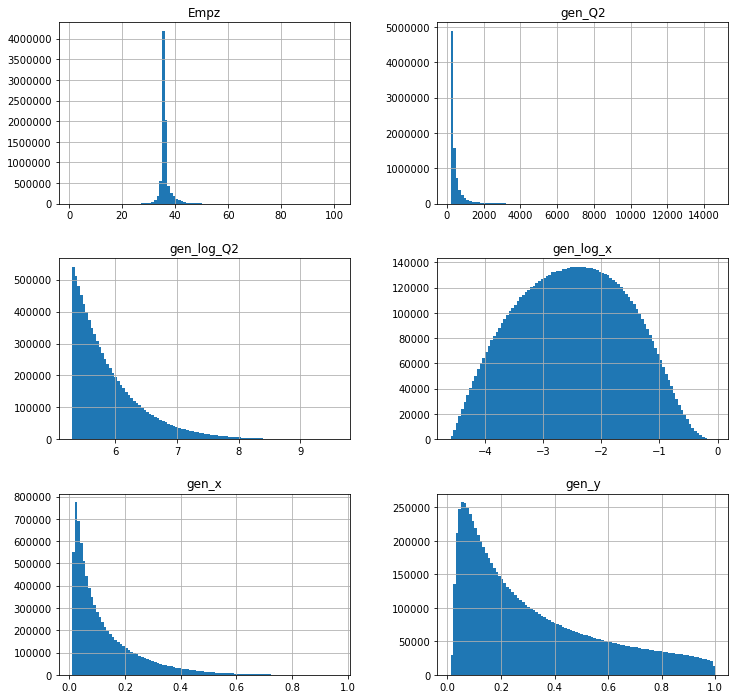

In [10]:
pandas_df.hist(figsize=(12,12), bins=100, column=['Empz','gen_y','gen_x','gen_log_x','gen_Q2','gen_log_Q2'])
plt.show()

In [11]:
pandas_df

,gene_px,gene_py,gene_pz,e_px,e_py,e_pz,HFS_px,HFS_py,HFS_pz,HFS_E,...,e_Empz,gene_Empz,s,gen_x,gen_log_x,gen_log_Q2,rot_pt1,rot_pt2,rot_Empz1,rot_Empz2
entry,,,,,,,,,,,,,,,,,,,,,
0,-7.121248,-12.914615,-13.887268,-7.156896,-12.979266,-13.956788,6.004340,12.465102,61.221779,63.056351,...,34.315434,34.144505,19800.000000,0.224727,-1.492870,5.435109,-0.697091,20.263943,-22.967438,25.561913
1,-14.146625,4.915292,-11.414117,-14.093822,4.896943,-11.371512,12.212230,-5.504359,27.414705,32.831879,...,30.131233,30.244125,19800.000000,0.084333,-2.472988,5.587142,-1.078285,20.022228,-17.475479,25.136520
2,-10.514571,-11.242774,-9.968884,-10.452328,-11.176219,-9.909869,8.446683,9.736281,20.870665,26.771954,...,28.140736,28.308317,19800.000000,0.071232,-2.641815,5.708237,-1.706010,19.934647,-15.725662,24.071346
3,3.355989,20.810322,-10.797507,3.343029,20.729967,-10.755816,-4.344270,-21.881338,197.288101,198.876633,...,34.348080,34.481220,19800.000000,0.555504,-0.587880,6.139664,0.926752,30.622118,-23.164499,25.411020
4,-12.956479,3.140606,-11.337905,-12.978569,3.145961,-11.357235,13.664036,-3.141085,21.651905,28.835464,...,28.887981,28.838814,19799.998047,0.056331,-2.876506,5.402082,0.470942,19.356932,-15.347343,25.506432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240544,2.712795,-14.897605,-14.248043,2.729255,-14.988000,-14.334496,-2.352442,15.209386,125.412598,126.371681,...,35.252594,35.039978,19799.998047,0.446323,-0.806713,5.462041,0.110147,21.654936,-24.249172,25.605522
4240545,13.761552,-10.741750,-10.959189,13.828179,-10.793756,-11.012248,-14.784962,13.626802,40.781078,45.872101,...,31.724400,31.571548,19800.000000,0.142681,-1.947144,5.850802,1.813574,26.621786,-18.832642,26.032433
4240546,-15.078546,9.823519,-12.346899,-15.147236,9.868270,-12.403145,13.210449,-9.879773,85.121117,86.973923,...,34.327095,34.171425,19800.000000,0.339300,-1.080871,5.832446,-1.118619,24.447823,-22.962790,25.583052


## Set up machine learning stuff

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#-- Ben suggested to try this.  2021-08-07
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=10,
               verbose=True,
               restore_best_weights=True)

import os

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

#####physical_devices = tf.config.list_physical_devices('CPU') 




[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Now feed in reco electron and reco HFS

This includes a variable transformation that decorrelates pt and Empz between the HFS and the electron.

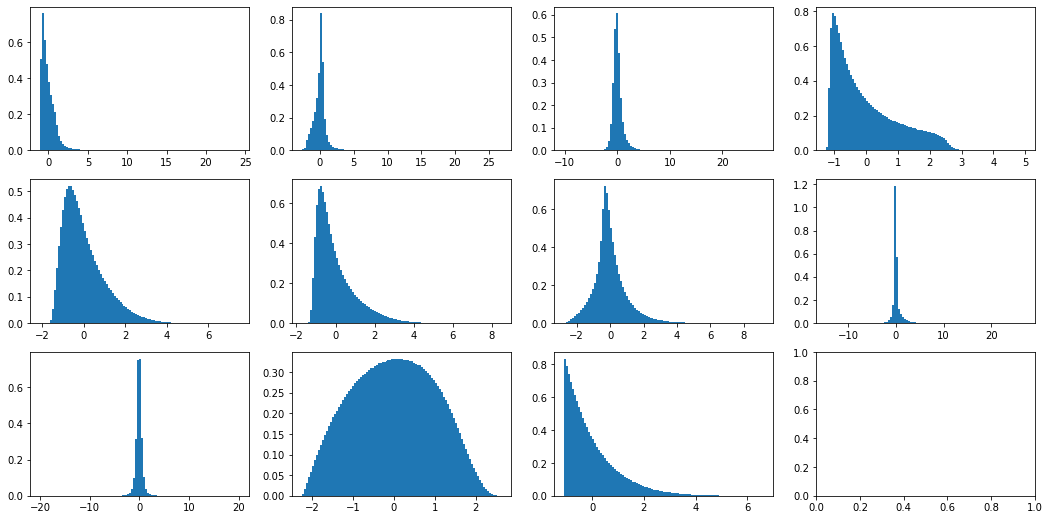

In [13]:
X3 = np.c_[ 
          pandas_df['e_pz'].to_numpy(),
          pandas_df['e_e'].to_numpy(),
          pandas_df['rot_pt1'].to_numpy(),
          pandas_df['rot_Empz1'].to_numpy(),
          pandas_df['HFS_pz'].to_numpy(),
          pandas_df['HFS_E'].to_numpy(),
          pandas_df['rot_pt2'].to_numpy(),
          pandas_df['rot_Empz2'].to_numpy(),
          pandas_df['dphi'].to_numpy(),
         ]

Y3 = np.c_[
    pandas_df['gen_log_x'].to_numpy(),
    pandas_df['gen_log_Q2'].to_numpy(),
]

scaler3 = StandardScaler()
scaler3.fit(X3)
X3 = scaler3.transform(X3)

#Y3 = Y3.reshape(-1,1)
scalerY3 = StandardScaler()
scalerY3.fit(Y3)
Y3 = scalerY3.transform(Y3)

GY3 = pandas_df['gen_y'].to_numpy()

X3_train, X3_test, Y3_train, Y3_test, GY3_train, GY3_test = train_test_split( X3, Y3, GY3, test_size=0.5)

fig,ax = plt.subplots(3,4,figsize=(18,9))
for i in range(4):
    ax[0][i].hist( X3[:,i],density=True,bins=100)
for i in range(4):
    ax[1][i].hist( X3[:,i+4],density=True,bins=100)

    
ax[2][0].hist( X3[:,8],density=True,bins=100)


    
ax[2][1].hist( Y3[:,0],density=True,bins=100)
    
ax[2][2].hist( Y3[:,1],density=True,bins=100)


plt.show()

In [14]:
model3 = Sequential()

#-- initial layer
model3.add(Dense(64, input_dim=9, activation='relu'))
model3.add(Dropout(dropout_setval))



#-- middle part
model3.add(Dense(128, activation='selu'))
model3.add(Dropout(dropout_setval))
model3.add(Dense(512, activation='selu'))
model3.add(Dropout(dropout_setval))
model3.add(Dense(1024, activation='selu'))
model3.add(Dropout(dropout_setval))
model3.add(Dense(512, activation='selu'))
model3.add(Dropout(dropout_setval))
model3.add(Dense(128, activation='selu'))
model3.add(Dropout(dropout_setval))




#-- final layers
model3.add(Dense(64, activation='selu'))
model3.add(Dense(2, activation='linear'))



opt3 = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval)
myloss3 = tf.keras.losses.Huber()

model3.compile(loss=myloss3, optimizer=opt3, metrics=['accuracy'])

model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              5

In [15]:
%%time

hist3 = model3.fit(
    X3_train, Y3_train, 
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1, 
    validation_data=(X3_test,Y3_test), 
    callbacks=[earlystopping] )

Epoch 1/5000
33079/33079 [==============================] - 93s 3ms/step - loss: 0.0017 - accuracy: 0.9902 - val_loss: 8.5372e-04 - val_accuracy: 0.9947
Epoch 2/5000
33079/33079 [==============================] - 93s 3ms/step - loss: 8.3240e-04 - accuracy: 0.9938 - val_loss: 9.8081e-04 - val_accuracy: 0.9940
Epoch 3/5000
33079/33079 [==============================] - 90s 3ms/step - loss: 7.3560e-04 - accuracy: 0.9945 - val_loss: 8.8567e-04 - val_accuracy: 0.9951
Epoch 4/5000
33079/33079 [==============================] - 92s 3ms/step - loss: 6.9000e-04 - accuracy: 0.9948 - val_loss: 6.3751e-04 - val_accuracy: 0.9951
Epoch 5/5000
33079/33079 [==============================] - 92s 3ms/step - loss: 6.6405e-04 - accuracy: 0.9951 - val_loss: 5.9909e-04 - val_accuracy: 0.9956
Epoch 6/5000
33079/33079 [==============================] - 93s 3ms/step - loss: 6.4464e-04 - accuracy: 0.9952 - val_loss: 6.7921e-04 - val_accuracy: 0.9953
Epoch 7/5000
33079/33079 [==============================] - 90

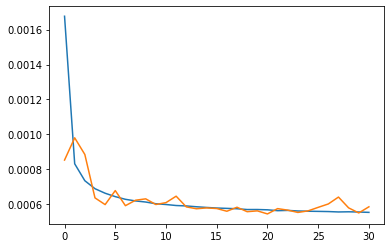

In [16]:
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])

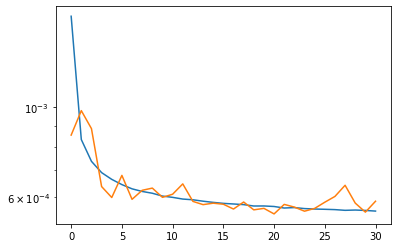

In [17]:
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.yscale('log')

In [18]:
tf.keras.models.save_model(model3,"model_output_athena_train_2d_v1b")

INFO:tensorflow:Assets written to: model_output_athena_train_2d_v1b/assets


In [19]:
mypreds3 = model3.predict(X3_test,batch_size=1000)

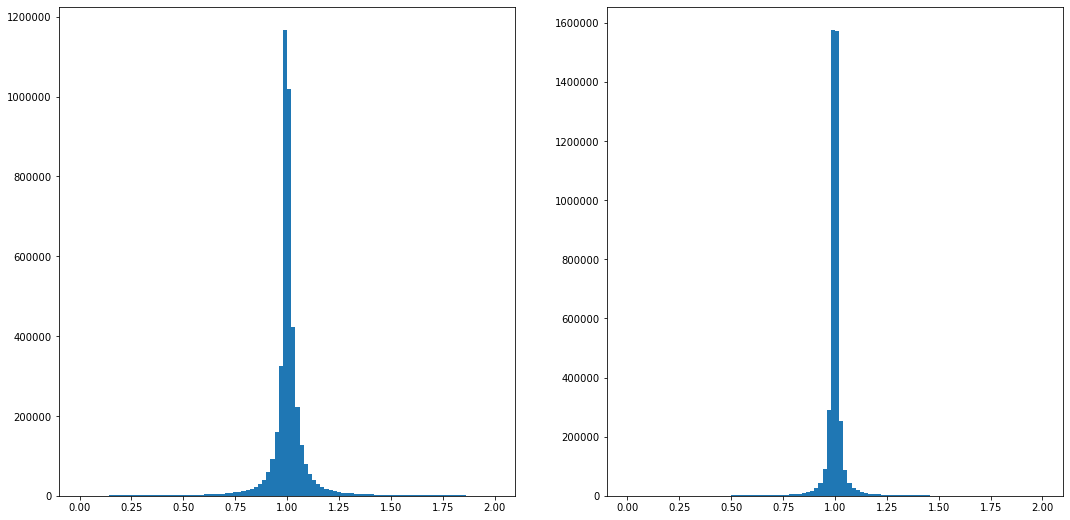

In [20]:
fig,ax = plt.subplots(1,2,figsize=(18,9))
ax[0].hist(mypreds3[:,0]/Y3_test[:,0],bins=100, range=[0,2] )
ax[1].hist(mypreds3[:,1]/Y3_test[:,1],bins=100, range=[0,2] )
plt.show()

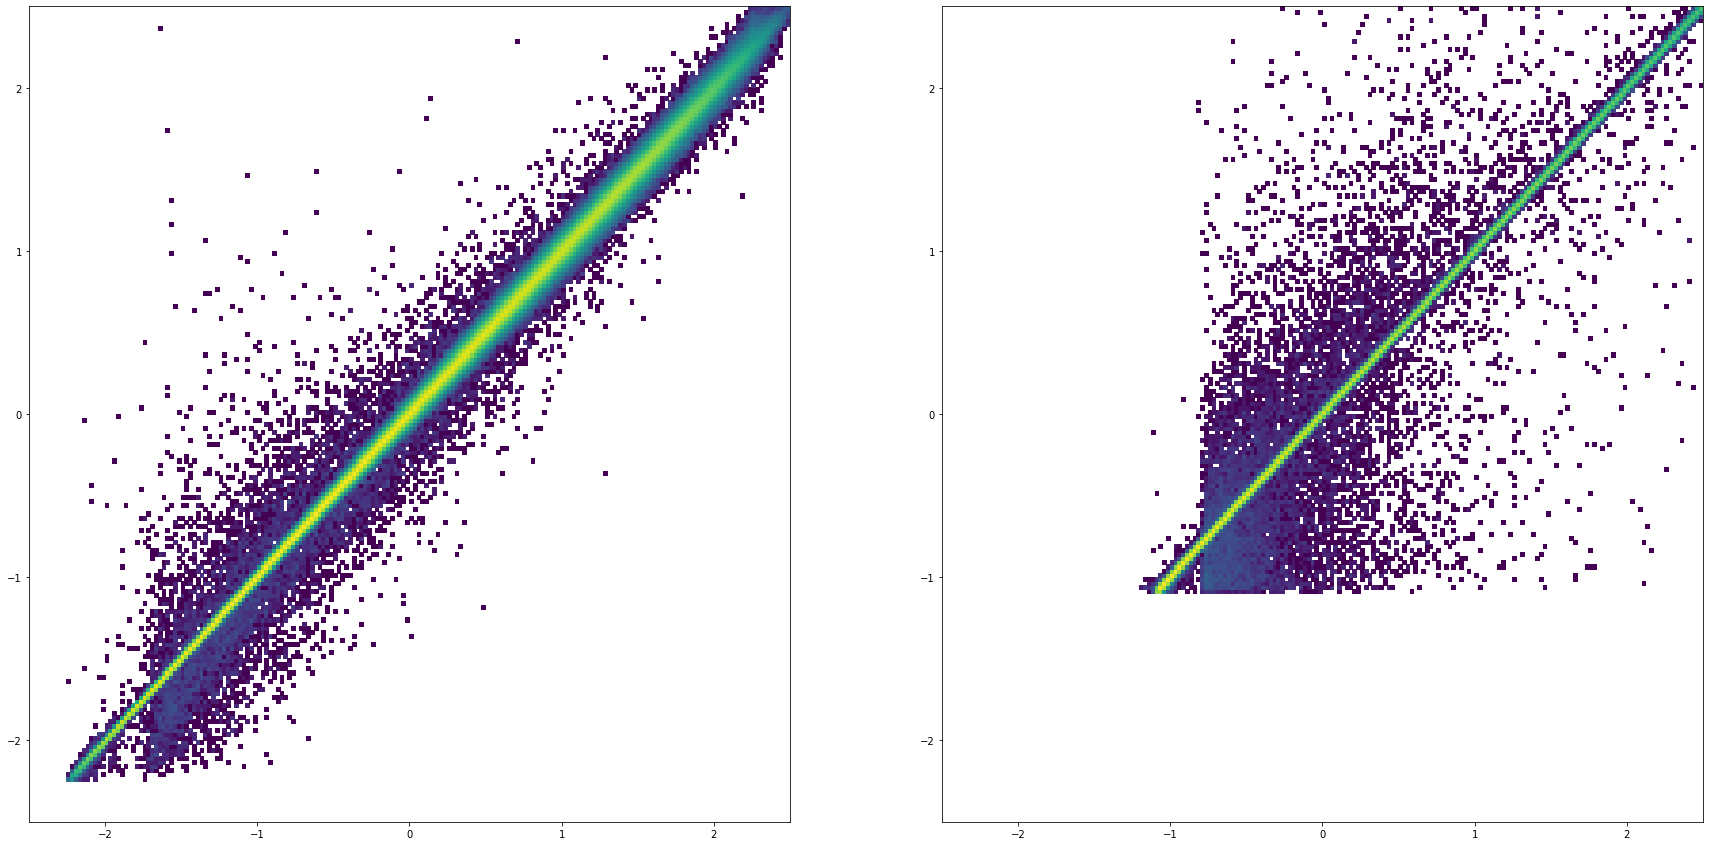

In [21]:
fig,ax = plt.subplots(1,2,figsize=(30,15))
ax[0].hist2d(mypreds3[:,0],Y3_test[:,0],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
ax[1].hist2d(mypreds3[:,1],Y3_test[:,1],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
plt.show()

In [22]:
inv_trans_Y = scalerY3.inverse_transform(Y3_test)
inv_trans_pred = scalerY3.inverse_transform(mypreds3)
true_vals = np.exp( inv_trans_Y )
pred_vals = np.exp( inv_trans_pred )

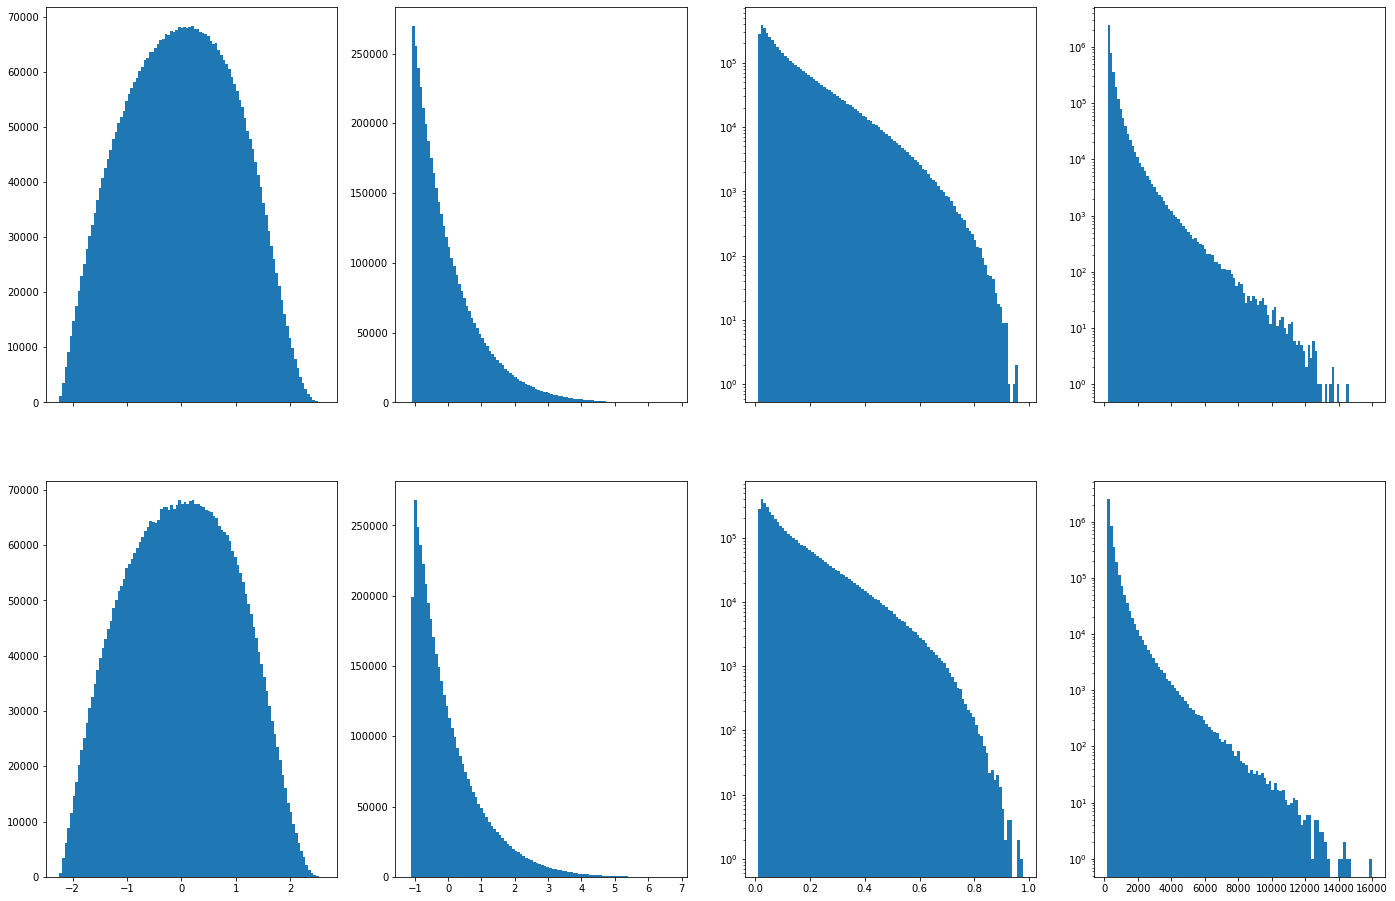

In [23]:
fig,ax = plt.subplots(2,4,figsize=(24,16), sharex='col')

ax[0][0].hist(Y3_test[:,0], bins=100)
ax[0][1].hist(Y3_test[:,1], bins=100)
ax[0][2].hist(true_vals[:,0], bins=100)
ax[0][3].hist(true_vals[:,1], bins=100)

ax[1][0].hist(mypreds3[:,0], bins=100)
ax[1][1].hist(mypreds3[:,1], bins=100)
ax[1][2].hist(pred_vals[:,0], bins=100)
ax[1][3].hist(pred_vals[:,1], bins=100)


ax[0][2].set_yscale('log')
ax[0][3].set_yscale('log')

ax[1][2].set_yscale('log')
ax[1][3].set_yscale('log')

plt.show()

## Plots of pred/true of training target variables : transformed log(x) and transformed log(Q2)

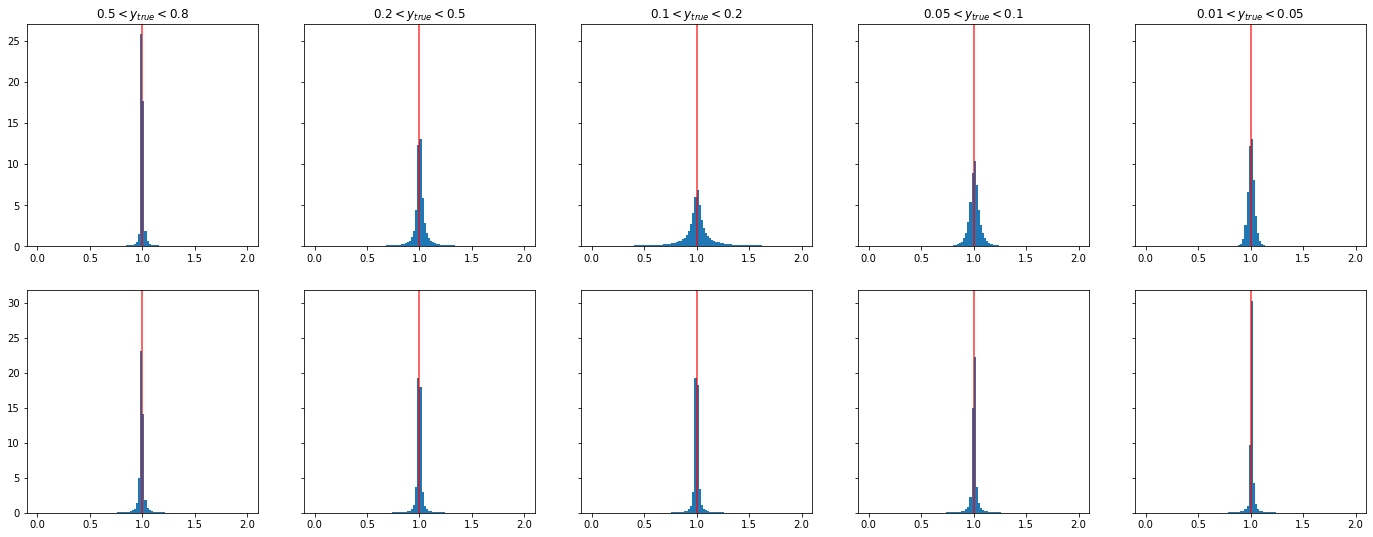

In [24]:
fig,ax = plt.subplots(2,5,figsize=(24,9),sharey='row')

ax[0][0].hist(mypreds3[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)]/Y3_test[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[0][1].hist(mypreds3[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)]/Y3_test[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[0][2].hist(mypreds3[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)]/Y3_test[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[0][3].hist(mypreds3[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)]/Y3_test[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[0][4].hist(mypreds3[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)]/Y3_test[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[1][0].hist(mypreds3[:,1][(GY3_test > 0.5)*(GY3_test < 0.8)]/Y3_test[(GY3_test > 0.5)*(GY3_test < 0.8)][:,1],density=True,bins=100,range=(0,2))
ax[1][1].hist(mypreds3[:,1][(GY3_test > 0.2)*(GY3_test < 0.5)]/Y3_test[(GY3_test > 0.2)*(GY3_test < 0.5)][:,1],density=True,bins=100,range=(0,2))
ax[1][2].hist(mypreds3[:,1][(GY3_test > 0.1)*(GY3_test < 0.2)]/Y3_test[(GY3_test > 0.1)*(GY3_test < 0.2)][:,1],density=True,bins=100,range=(0,2))
ax[1][3].hist(mypreds3[:,1][(GY3_test > 0.05)*(GY3_test < 0.1)]/Y3_test[(GY3_test > 0.05)*(GY3_test < 0.1)][:,1],density=True,bins=100,range=(0,2))
ax[1][4].hist(mypreds3[:,1][(GY3_test > 0.01)*(GY3_test < 0.05)]/Y3_test[(GY3_test > 0.01)*(GY3_test < 0.05)][:,1],density=True,bins=100,range=(0,2))



ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[0][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    ax[1][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()



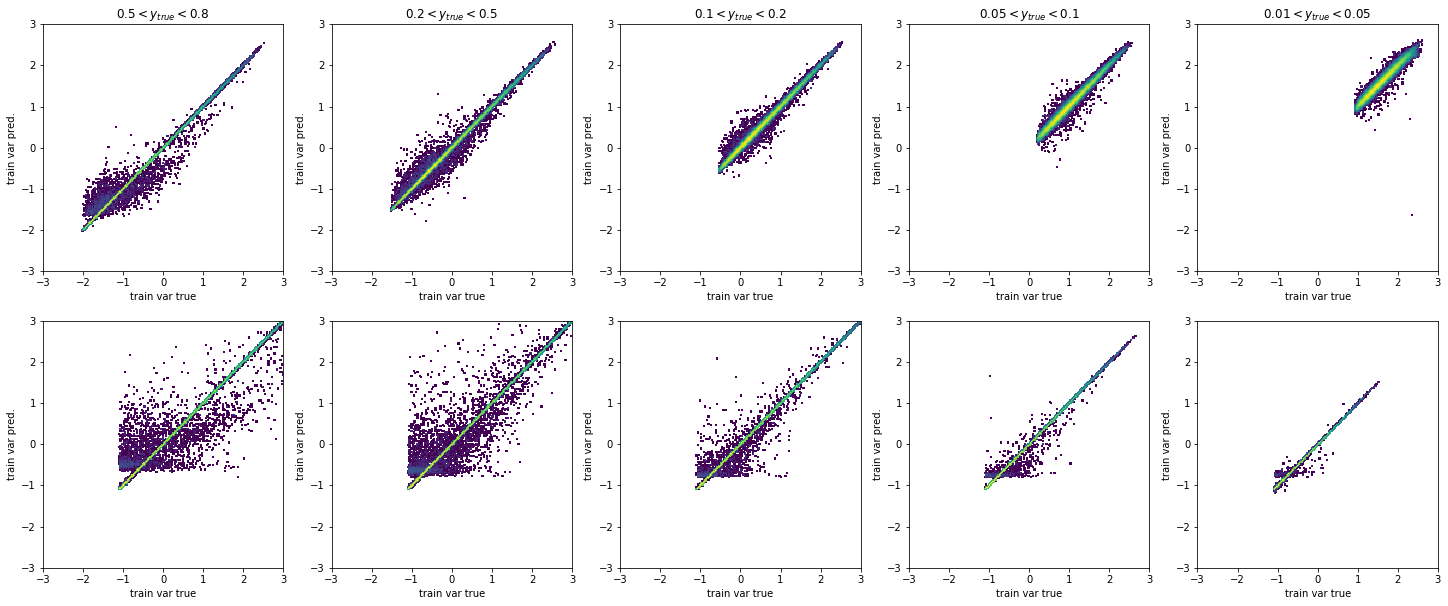

In [25]:
fig,ax = plt.subplots(2,5,figsize=(25,10))



ax[0][0].hist2d( Y3_test[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],
              mypreds3[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

ax[0][1].hist2d( Y3_test[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],
              mypreds3[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

ax[0][2].hist2d( Y3_test[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],
              mypreds3[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

ax[0][3].hist2d( Y3_test[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],
              mypreds3[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

ax[0][4].hist2d( Y3_test[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],
              mypreds3[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())



ax[1][0].hist2d( Y3_test[(GY3_test > 0.5)*(GY3_test < 0.8)][:,1],
              mypreds3[:,1][(GY3_test > 0.5)*(GY3_test < 0.8)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

ax[1][1].hist2d( Y3_test[(GY3_test > 0.2)*(GY3_test < 0.5)][:,1],
              mypreds3[:,1][(GY3_test > 0.2)*(GY3_test < 0.5)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

ax[1][2].hist2d( Y3_test[(GY3_test > 0.1)*(GY3_test < 0.2)][:,1],
              mypreds3[:,1][(GY3_test > 0.1)*(GY3_test < 0.2)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

ax[1][3].hist2d( Y3_test[(GY3_test > 0.05)*(GY3_test < 0.1)][:,1],
              mypreds3[:,1][(GY3_test > 0.05)*(GY3_test < 0.1)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

ax[1][4].hist2d( Y3_test[(GY3_test > 0.01)*(GY3_test < 0.05)][:,1],
              mypreds3[:,1][(GY3_test > 0.01)*(GY3_test < 0.05)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())





ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')




for i in range(5):
    ax[0][i].set_ylabel('train var pred.')
    ax[0][i].set_xlabel('train var true')
    ax[1][i].set_ylabel('train var pred.')
    ax[1][i].set_xlabel('train var true')




    
plt.show()

## Plots of predicted and true physics variable : x

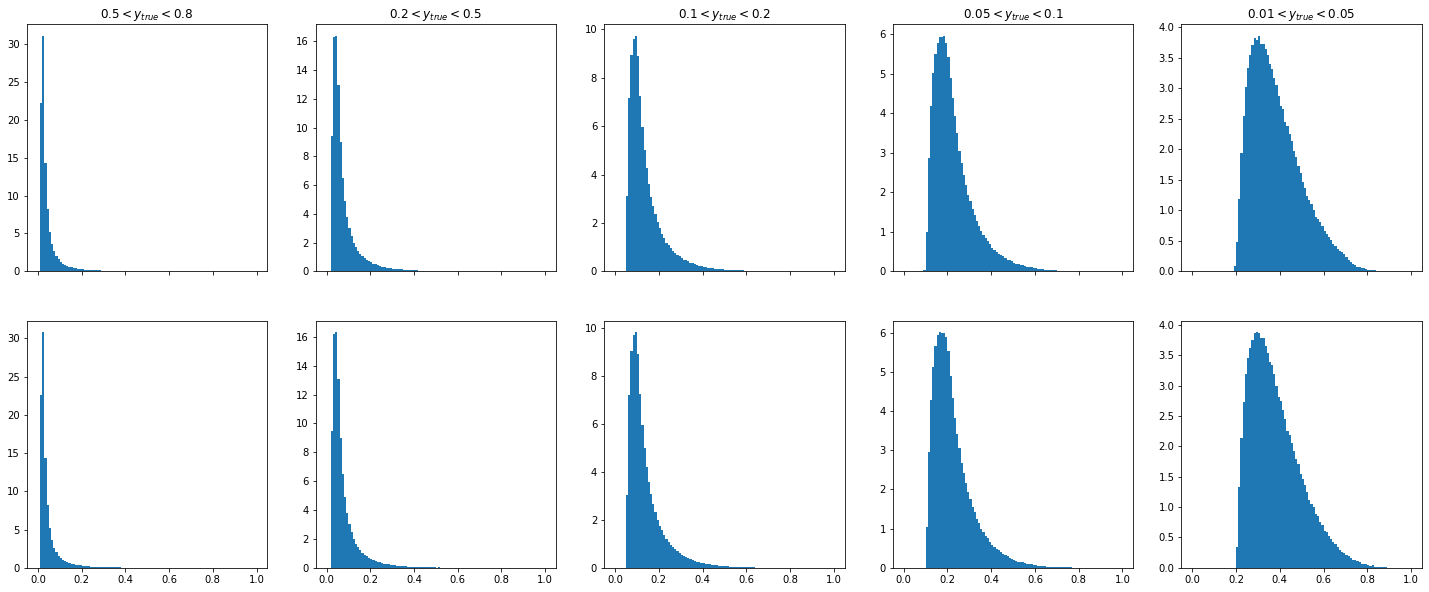

In [26]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

ax[0][0].hist(pred_vals[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)],density=True,bins=100,range=(0,1))
ax[0][1].hist(pred_vals[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)],density=True,bins=100,range=(0,1))
ax[0][2].hist(pred_vals[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)],density=True,bins=100,range=(0,1))
ax[0][3].hist(pred_vals[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)],density=True,bins=100,range=(0,1))
ax[0][4].hist(pred_vals[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)],density=True,bins=100,range=(0,1))

ax[1][0].hist(true_vals[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)],density=True,bins=100,range=(0,1))
ax[1][1].hist(true_vals[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)],density=True,bins=100,range=(0,1))
ax[1][2].hist(true_vals[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)],density=True,bins=100,range=(0,1))
ax[1][3].hist(true_vals[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)],density=True,bins=100,range=(0,1))
ax[1][4].hist(true_vals[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)],density=True,bins=100,range=(0,1))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

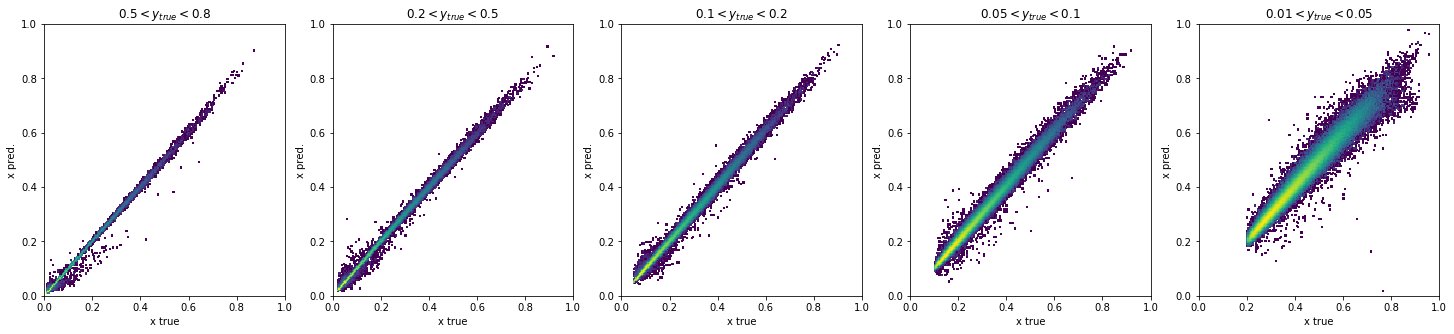

In [27]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

ax[0].hist2d( true_vals[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)],
              pred_vals[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)],
              pred_vals[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)],
              pred_vals[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)],
              pred_vals[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)],
              pred_vals[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('x pred.')
    ax[i].set_xlabel('x true')


    
plt.show()

## Plots of predicted and true physics variable : Q2

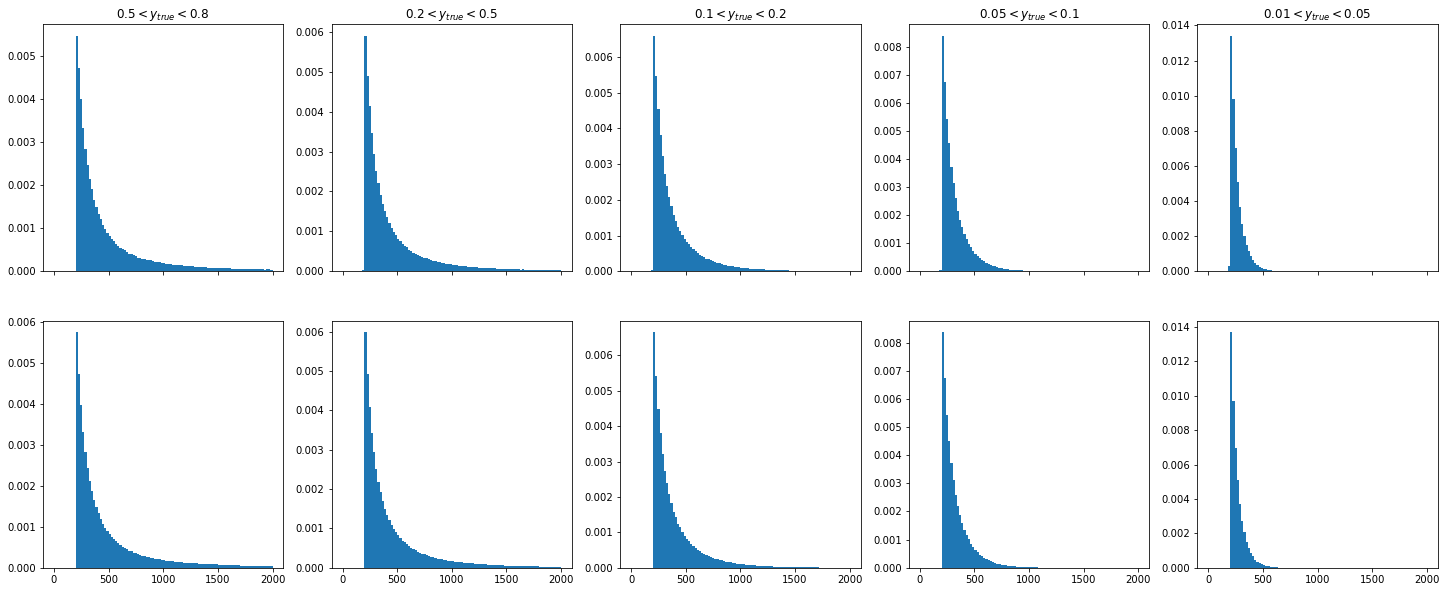

In [28]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

xmax = 2000

ax[0][0].hist(pred_vals[:,1][(GY3_test > 0.5)*(GY3_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[0][1].hist(pred_vals[:,1][(GY3_test > 0.2)*(GY3_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[0][2].hist(pred_vals[:,1][(GY3_test > 0.1)*(GY3_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[0][3].hist(pred_vals[:,1][(GY3_test > 0.05)*(GY3_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[0][4].hist(pred_vals[:,1][(GY3_test > 0.01)*(GY3_test < 0.05)],density=True,bins=100,range=(0,xmax))

ax[1][0].hist(true_vals[:,1][(GY3_test > 0.5)*(GY3_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[1][1].hist(true_vals[:,1][(GY3_test > 0.2)*(GY3_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[1][2].hist(true_vals[:,1][(GY3_test > 0.1)*(GY3_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[1][3].hist(true_vals[:,1][(GY3_test > 0.05)*(GY3_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[1][4].hist(true_vals[:,1][(GY3_test > 0.01)*(GY3_test < 0.05)],density=True,bins=100,range=(0,xmax))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

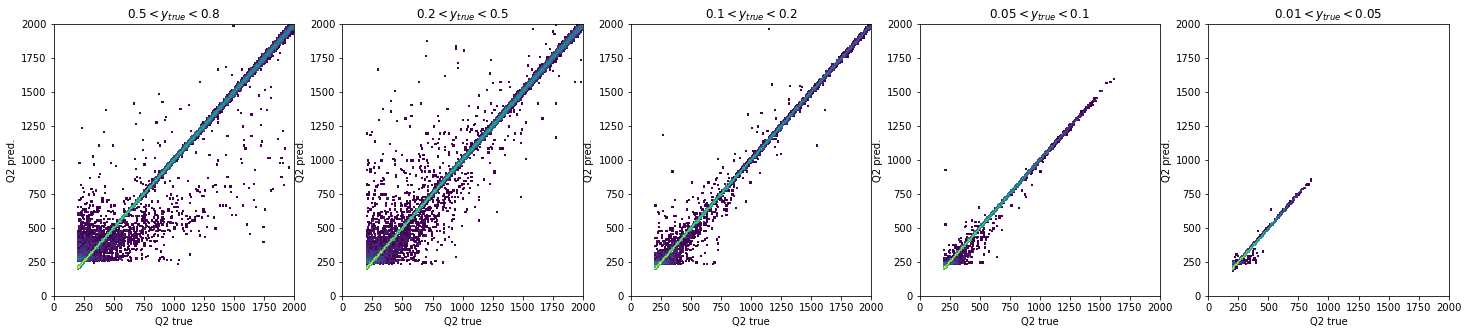

In [29]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

axis_max = 2000

ax[0].hist2d( true_vals[:,1][(GY3_test > 0.5)*(GY3_test < 0.8)],
              pred_vals[:,1][(GY3_test > 0.5)*(GY3_test < 0.8)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,1][(GY3_test > 0.2)*(GY3_test < 0.5)],
              pred_vals[:,1][(GY3_test > 0.2)*(GY3_test < 0.5)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,1][(GY3_test > 0.1)*(GY3_test < 0.2)],
              pred_vals[:,1][(GY3_test > 0.1)*(GY3_test < 0.2)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,1][(GY3_test > 0.05)*(GY3_test < 0.1)],
              pred_vals[:,1][(GY3_test > 0.05)*(GY3_test < 0.1)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,1][(GY3_test > 0.01)*(GY3_test < 0.05)],
              pred_vals[:,1][(GY3_test > 0.01)*(GY3_test < 0.05)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('Q2 pred.')
    ax[i].set_xlabel('Q2 true')


    
plt.show()

## Plots of pred/true of physics variable:  x

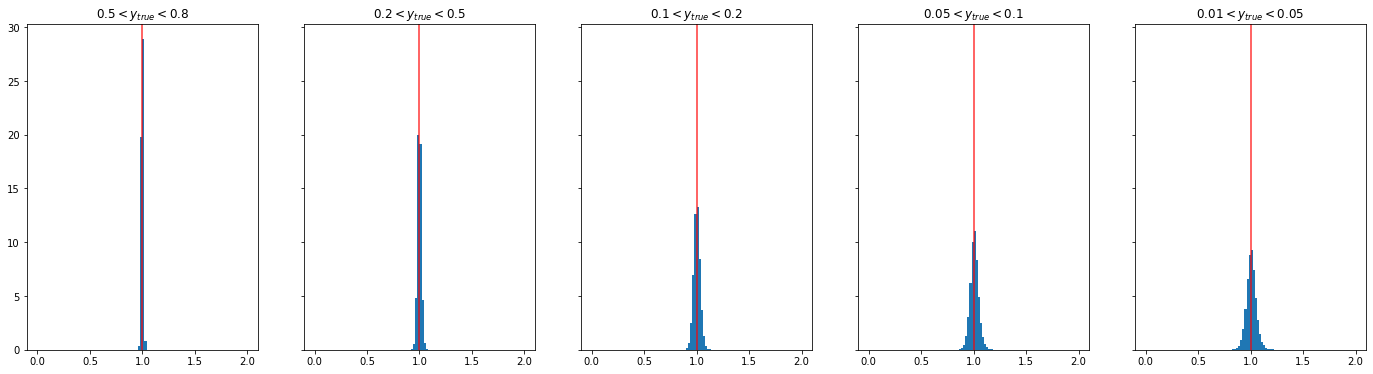

In [30]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(pred_vals[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)]/true_vals[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)], density=True,bins=100,range=(0,2))
ax[1].hist(pred_vals[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)]/true_vals[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)], density=True,bins=100,range=(0,2))
ax[2].hist(pred_vals[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)]/true_vals[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)], density=True,bins=100,range=(0,2))
ax[3].hist(pred_vals[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)]/true_vals[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)], density=True,bins=100,range=(0,2))
ax[4].hist(pred_vals[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)]/true_vals[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)], density=True,bins=100,range=(0,2))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Plots of pred/true of physics variable: Q2

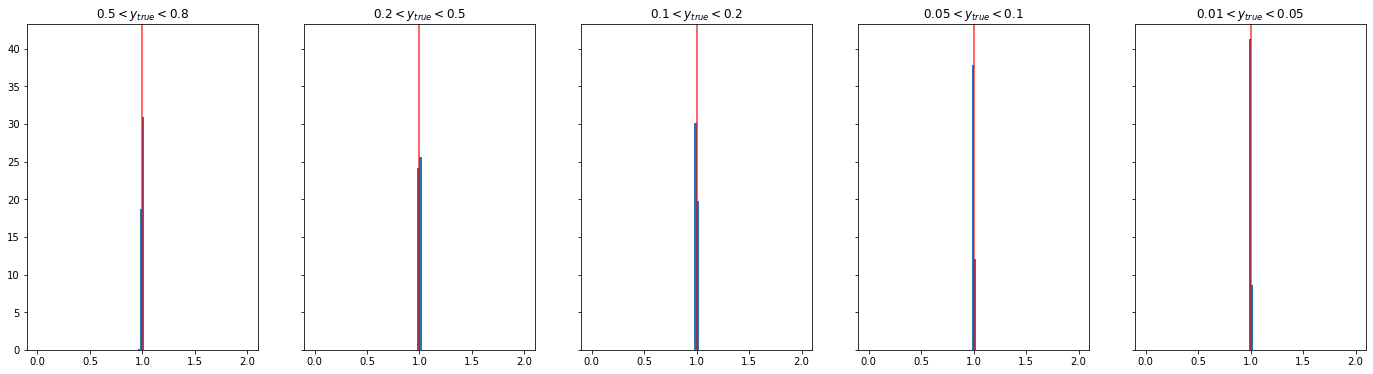

In [31]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(pred_vals[:,1][(GY3_test > 0.5)*(GY3_test < 0.8)]/true_vals[:,1][(GY3_test > 0.5)*(GY3_test < 0.8)], density=True,bins=100,range=(0,2))
ax[1].hist(pred_vals[:,1][(GY3_test > 0.2)*(GY3_test < 0.5)]/true_vals[:,1][(GY3_test > 0.2)*(GY3_test < 0.5)], density=True,bins=100,range=(0,2))
ax[2].hist(pred_vals[:,1][(GY3_test > 0.1)*(GY3_test < 0.2)]/true_vals[:,1][(GY3_test > 0.1)*(GY3_test < 0.2)], density=True,bins=100,range=(0,2))
ax[3].hist(pred_vals[:,1][(GY3_test > 0.05)*(GY3_test < 0.1)]/true_vals[:,1][(GY3_test > 0.05)*(GY3_test < 0.1)], density=True,bins=100,range=(0,2))
ax[4].hist(pred_vals[:,1][(GY3_test > 0.01)*(GY3_test < 0.05)]/true_vals[:,1][(GY3_test > 0.01)*(GY3_test < 0.05)], density=True,bins=100,range=(0,2))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Standard comparison plots

In [32]:

pandas_df.eval('s = 4*27.6*920', inplace=True)
pandas_df.eval('x_e = Q2_e/(s*y_e)',inplace=True)
pandas_df.eval('x_da = Q2_da/(s*y_da)',inplace=True)
pandas_df.eval('x_sigma = Q2_sigma/(s*y_sigma)',inplace=True)
pandas_df.eval('x_h = Q2_h/(s*y_h)',inplace=True)



pandas_df.eval('gen_x= gen_Q2/(s*gen_y)', inplace=True)   

pandas_df.eval('xe_ratio = x_e/gen_x',inplace=True)
pandas_df.eval('xda_ratio = x_da/gen_x',inplace=True)
pandas_df.eval('xsigma_ratio = x_sigma/gen_x',inplace=True)
pandas_df.eval('xh_ratio = x_h/gen_x',inplace=True)
        

['gen_y>0.5 and gen_y<0.8' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.8
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


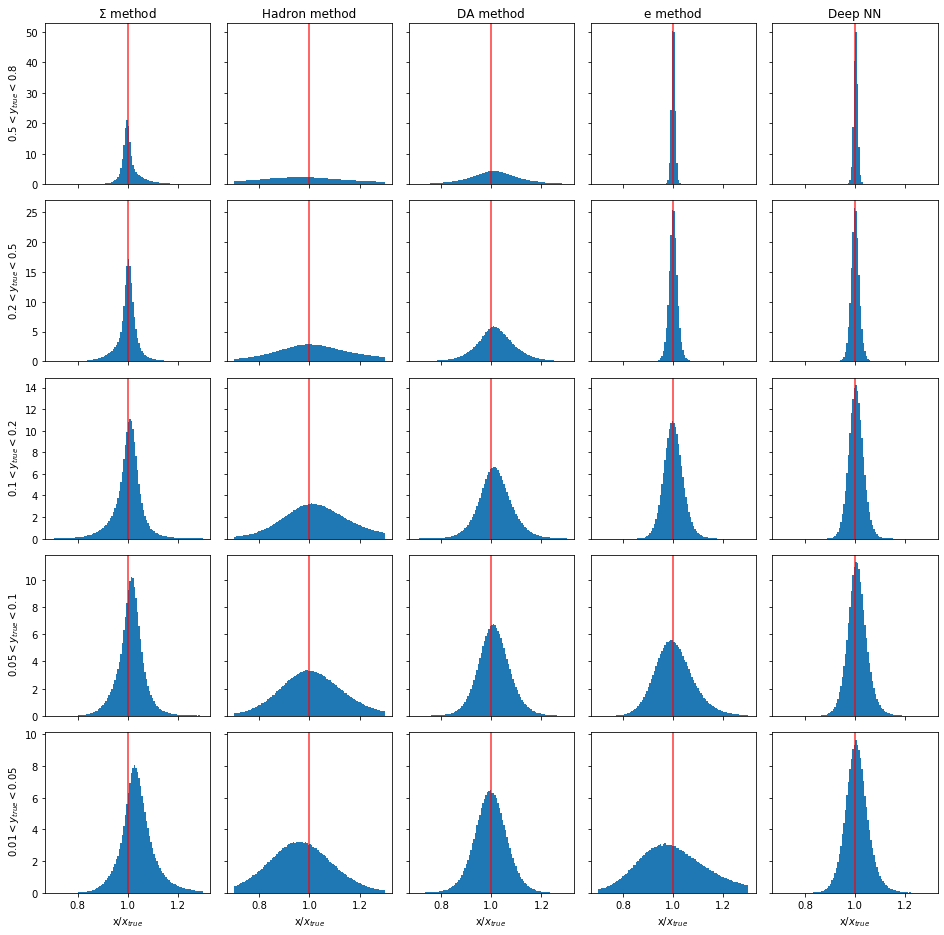

In [33]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.8', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)

xmin=0.7
xmax=1.3

for i in range(5):
    print(ybins[i])
    ax[0 + 5*i].hist(pandas_df.query(ybins[i])['xsigma_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[1 + 5*i].hist(pandas_df.query(ybins[i])['xh_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[2 + 5*i].hist(pandas_df.query(ybins[i])['xda_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[3 + 5*i].hist(pandas_df.query(ybins[i])['xe_ratio'],density=True,bins=100,range=(xmin,xmax))

ax[4].hist(pred_vals[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)]/true_vals[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)],density=True,bins=100,range=(xmin,xmax))
ax[9].hist(pred_vals[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)]/true_vals[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)],density=True,bins=100,range=(xmin,xmax))
ax[14].hist(pred_vals[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)]/true_vals[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)],density=True,bins=100,range=(xmin,xmax))
ax[19].hist(pred_vals[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)]/true_vals[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)],density=True,bins=100,range=(xmin,xmax))
ax[24].hist(pred_vals[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)]/true_vals[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)],density=True,bins=100,range=(xmin,xmax))
    
for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    #ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[3].set_title('e method')
ax[2].set_title('DA method')
ax[0].set_title('$\Sigma$ method')
ax[1].set_title('Hadron method')
ax[4].set_title('Deep NN')


ax[0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[4+1].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8+1+1].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12+1+1+1].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16+1+1+1+1].set_ylabel(' $0.01<y_{true}<0.05$')

ax[-1].set_xlabel(r'x/$x_{true}$ ')
ax[-2].set_xlabel(r'x/$x_{true}$ ')
ax[-3].set_xlabel(r'x/$x_{true}$ ')
ax[-4].set_xlabel(r'x/$x_{true}$ ')
ax[-5].set_xlabel(r'x/$x_{true}$ ')


plt.show()

In [34]:
pandas_df.eval('Q2e_ratio = Q2_e/gen_Q2',inplace=True)
pandas_df.eval('Q2da_ratio = Q2_da/gen_Q2',inplace=True)
pandas_df.eval('Q2sigma_ratio = Q2_sigma/gen_Q2',inplace=True)
pandas_df.eval('Q2h_ratio = Q2_h/gen_Q2',inplace=True)

['gen_y>0.5 and gen_y<0.8' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.8
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


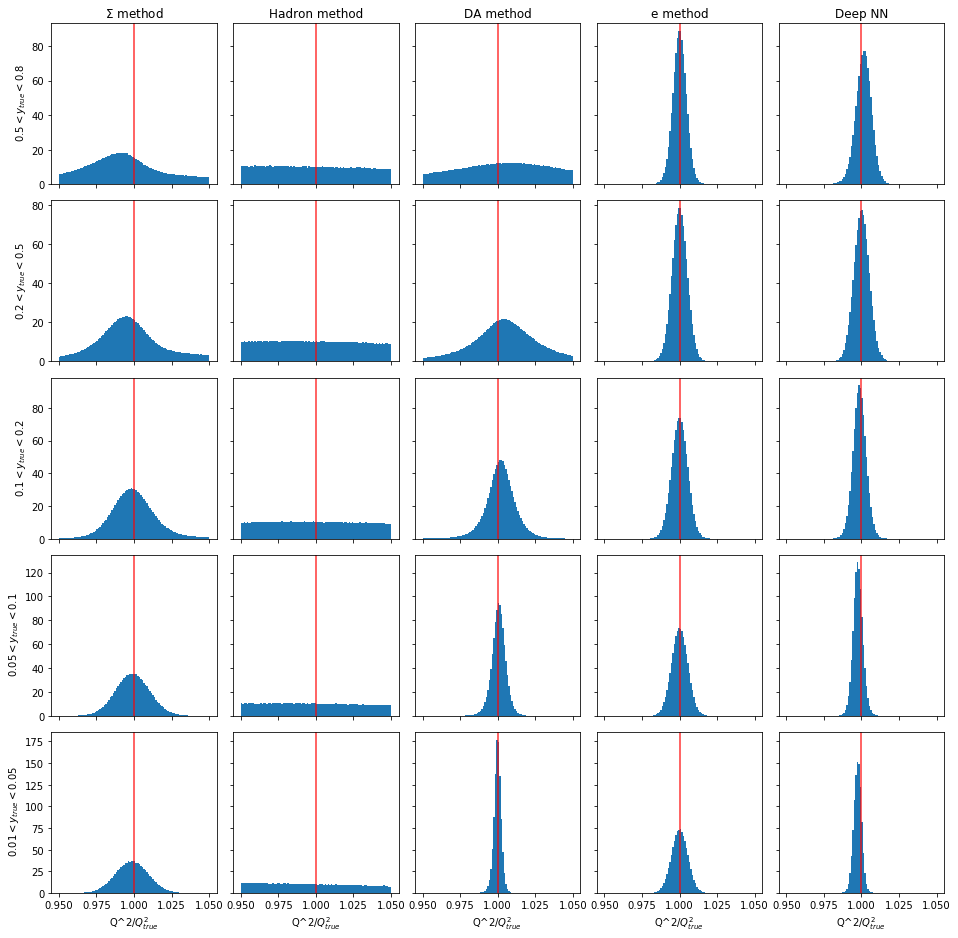

In [36]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.8', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)

xmin=0.95
xmax=1.05

for i in range(5):
    print(ybins[i])
    ax[0 + 5*i].hist(pandas_df.query(ybins[i])['Q2sigma_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[1 + 5*i].hist(pandas_df.query(ybins[i])['Q2h_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[2 + 5*i].hist(pandas_df.query(ybins[i])['Q2da_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[3 + 5*i].hist(pandas_df.query(ybins[i])['Q2e_ratio'],density=True,bins=100,range=(xmin,xmax))

ax[4].hist(pred_vals[:,1][(GY3_test > 0.5)*(GY3_test < 0.8)]/true_vals[:,1][(GY3_test > 0.5)*(GY3_test < 0.8)],density=True,bins=100,range=(xmin,xmax))
ax[9].hist(pred_vals[:,1][(GY3_test > 0.2)*(GY3_test < 0.5)]/true_vals[:,1][(GY3_test > 0.2)*(GY3_test < 0.5)],density=True,bins=100,range=(xmin,xmax))
ax[14].hist(pred_vals[:,1][(GY3_test > 0.1)*(GY3_test < 0.2)]/true_vals[:,1][(GY3_test > 0.1)*(GY3_test < 0.2)],density=True,bins=100,range=(xmin,xmax))
ax[19].hist(pred_vals[:,1][(GY3_test > 0.05)*(GY3_test < 0.1)]/true_vals[:,1][(GY3_test > 0.05)*(GY3_test < 0.1)],density=True,bins=100,range=(xmin,xmax))
ax[24].hist(pred_vals[:,1][(GY3_test > 0.01)*(GY3_test < 0.05)]/true_vals[:,1][(GY3_test > 0.01)*(GY3_test < 0.05)],density=True,bins=100,range=(xmin,xmax))
    
for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    #ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[3].set_title('e method')
ax[2].set_title('DA method')
ax[0].set_title('$\Sigma$ method')
ax[1].set_title('Hadron method')
ax[4].set_title('Deep NN')


ax[0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[4+1].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8+1+1].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12+1+1+1].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16+1+1+1+1].set_ylabel(' $0.01<y_{true}<0.05$')

ax[-1].set_xlabel(r'Q^2/$Q^2_{true}$ ')
ax[-2].set_xlabel(r'Q^2/$Q^2_{true}$ ')
ax[-3].set_xlabel(r'Q^2/$Q^2_{true}$ ')
ax[-4].set_xlabel(r'Q^2/$Q^2_{true}$ ')
ax[-5].set_xlabel(r'Q^2/$Q^2_{true}$ ')


plt.show()